# Hansen et al. Forest loss data

The data is in geotiff format, split into pieces

I downloaded the "lossyear" data version 1.7  
https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html

Which is described as:  
**Year of gross forest cover loss event (lossyear)**  
Forest loss during the period 2000–2019, defined as a stand-replacement disturbance, or a change from a forest to non-forest state. Encoded as either 0 (no loss) or else a value in the range 1–17, representing loss detected primarily in the year 2001–2019, respectively.

Use the following credit when these data are displayed:  
Source: Hansen/UMD/Google/USGS/NASA  

Use the following credit when these data are cited:  

Hansen, M. C., P. V. Potapov, R. Moore, M. Hancher, S. A. Turubanova, A. Tyukavina, D. Thau, S. V. Stehman, S. J. Goetz, T. R. Loveland, A. Kommareddy, A. Egorov, L. Chini, C. O. Justice, and J. R. G. Townshend. 2013. “High-Resolution Global Maps of 21st-Century Forest Cover Change.” Science 342 (15 November): 850–53. Data available on-line from: http://earthenginepartners.appspot.com/science-2013-global-forest.

In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
import scipy
import xarray as xr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
## import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio.warp import transform
from affine import Affine
from osgeo import gdal, osr
from pyproj import Proj
import glob

In [3]:
# Memory clearing package 
import gc

## Locating regions of interest

The Hansen et al data is split into tiles. for our two regions we only need a few tiles

**Amazon:**  
10N_080W  
10N_070W  
10N_060W  
00N_080W  
00N_070W  
00N_060W  
00N_050W  
10S_080W  
10S_070W  
10S_060W  
10S_050W  
20S_070W  
20S_060W  
20S_050W  

(maybe)  
00N_040W   

**Western North America:**  
50N_130W  
50N_120W  
40N_130W  
40N_120W  
60N_140W  
60N_130W  
60N_120W  
60N_110W  

(maybe)  
50N_110W  
40N_110W  


**The data is TOO big to deal with many tiles at once**  
Therefore will have to come up with a way to coarsen the spatial scal, since that resoluton isn't necessary

How to do this? The data shows just a yes/no for forest loss in a particular year. So we could mask to have loss in any year, then convert that to an area

Will probably have to do this for each tile individually, maybe just the whole globe. Not sure how to merge the files but I'll deal with that later.

In [5]:
"""
loc = '10S_070W'
filename = 'Hansen_GFC-2019-v1.7_lossyear_' +loc +'.tif'
# one file:
#filename = 'Hansen_GFC-2019-v1.7_lossyear_40N_080W.tif'

inputFile=datapath +filename
"""

"\nloc = '10S_070W'\nfilename = 'Hansen_GFC-2019-v1.7_lossyear_' +loc +'.tif'\n# one file:\n#filename = 'Hansen_GFC-2019-v1.7_lossyear_40N_080W.tif'\n\ninputFile=datapath +filename\n"

In [4]:
#file_list = ['10N_080W', '10N_070W', '10N_060W', '00N_080W']

# File List all
"""
file_list = ['10N_080W', '10N_070W', '10N_060W', '00N_080W', '00N_070W', '00N_060W', '00N_050W',
              '10S_080W', '10S_070W', '10S_060W', '10S_050W', '20S_070W', '20S_060W', '20S_050W',
              '00N_040W', '50N_130W', '50N_120W', '40N_130W', '40N_120W', '60N_140W', '60N_130W',
              '60N_120W', '60N_110W', '50N_110W', '40N_110W']
"""

# File list select filler boxes
file_list = ['30N_100W', '20N_090W']

file_list_len = len(file_list)

In [5]:
datapath='/home/disk/eos3/aswann/Shared/Data/forestmaps/hansen_landsat_forestloss/'
filepath = datapath +'Hansen_GFC-2019-v1.7_lossyear_'
# filenamelist=sorted(glob.glob(filepath)) # find the combination of all of these lists

In [43]:
# change to loop over list of loc
for i in range(file_list_len): #len(filenamelist)): # Loops over all file names
    file_num=file_list[i] 
    filename = filepath + file_num
    print("Working on file #" + str(i + 1) + ": " + file_num)
    ds = xr.open_rasterio(filename +".tif")
    
    # Creates the empty result file 
    mapdata = ds.variable.data[0]
    nx, ny = ds.sizes['x'], ds.sizes['y']
    mapdata_size = mapdata.size
    mapdata_side = int(mapdata.shape[0])
    kernel = np.ones((int(mapdata_side/10), int(mapdata_side/10)))
    kernel_height, kernel_width = kernel.shape
    result_height = int(mapdata.shape[0]/kernel_height)
    result_width = result_height
    result = np.zeros((result_height, result_width, mapdata.max())) # lat, lon, year
    #print("Result shape: " + str(result.shape))
    
   # Loops thorugh data by year, and lat, and lon. Finds the percentage of each kernel
    map_max = mapdata.max() #Finds maximum year that data extends to
    print("Year:", end =" ")
    for year in range(mapdata.max()): # 0-18
        print(str(year), end =", ")
        binary = ds['band'].where(ds==(year+1)).values # 1-19
        binary = np.squeeze(binary) # Removes extra dimension 
        for lat in range(result_height): # Loops over all lat
            for lon in range(result_width): #loops over all lon
                curr = binary[lat*kernel_height:(lat+1)*kernel_height-1, lon*kernel_width:(lon+1)*kernel_width-1]
                result[lat, lon, year] = np.nansum(curr)/curr.size
                 
    # Establishes the lat and lon arrays with length 10, and the year
    years = np.arange(2000, 2019) # Establishes the years that the data spans
    lon_num = ds.transform[2]
    lat_num = ds.transform[5]
    lat = np.arange(lat_num-0.5, lat_num-10-0.5, -1) # Puts data point in the middle of the box
    lon = np.arange(lon_num+0.5, lon_num+10+0.5)
    #print(lon)
    #print(lat)
    
    # Creates xarray data set, using lon, lat, year already established 
    ds_result = xr.Dataset(
        {
            "Percent": (["lon", "lat", "year"], result), #make the same order as result
        },
        coords={
            "lon": (["lon"], lon),
            "lat": (["lat"], lat),
            "year": years #2000-2019 just in numbers
        },
    )
    
    # Saves as netcdf
    ds_result.to_netcdf(filename +".nc")
    #print(ds_result.head)
    print("File " + file_num + " is saved")
    print() #Spacing line
    del binary
    gc.collect()

Working on file #1: 30N_100W
Year: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, File 30N_100W is saved

Working on file #2: 20N_090W
Year: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, File 20N_090W is saved



In [ ]:
print(ds_result.head)

In [ ]:
ds_result.to_netcdf("/home/disk/eos3/aswann/Shared/Data/forestmaps/hansen_landsat_forestloss/Hansen_GFC-2019-v1.7_lossyear_00N_000E.nc")

In [5]:
ds_test = xr.open_dataset("/home/disk/eos3/aswann/Shared/Data/forestmaps/hansen_landsat_forestloss/Hansen_GFC-2019-v1.7_lossyear_40N_110W.nc")

In [22]:
ds_test.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (lat: 10, lon: 10, year: 19)
Coordinates:
  * lon      (lon) float64 -109.5 -108.5 -107.5 -106.5 ... -102.5 -101.5 -100.5
  * lat      (lat) float64 39.5 38.5 37.5 36.5 35.5 34.5 33.5 32.5 31.5 30.5
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017 2018
Data variables:
    Percent  (lon, lat, year) float64 0.0003091 0.01739 ... 4.702e-05 2.151e-05>

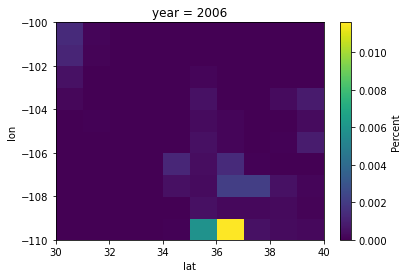

In [33]:
ds_test['Percent'][:,:,6].plot()

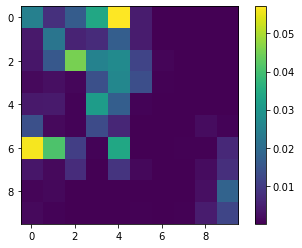

In [12]:
plt.imshow(np.sum(result[:,:,:], 2))
plt.colorbar()

In [ ]:
ds_result.plot.scatter("Percent", "year")


In [ ]:
# Other way to access lat lon values, but it seems to have long decimals  
ds['y'][0].values 
ds['x'][0].values

# Best one to use 
ds.transform[2] #lon value w/ negative instead of E, W
ds.transform[5] # Lat value w/ pos,neg 


In [ ]:
# Loop through numbers from string, not needed when +/- is already in number
lat_num = int(loc[0:2])#change to number (int? or float?)
lat_n_s = loc[2:3]# if statement to make lat positive or negative
if lat_n_s=="S":
    lat_num = (-1)*lat_num

lon_num = int(loc[4:7])
lon_n_s = loc[7:8]
if lon_n_s=="W":
    lon_num = (-1)*lon_num

# Use these with ds.transform to make the array and center boxes in the middle
lat = np.arange(lat_num-0.5, lat_num-10-0.5, -1) 
lon = np.arange(lon_num+0.5, lon_num+10+0.5)

In [9]:
# Code for one file 
filename = 'Hansen_GFC-2019-v1.7_lossyear_10S_070W.tif'
inputFile=datapath +filename
inputFile


'/home/disk/eos3/aswann/Shared/Data/forestmaps/hansen_landsat_forestloss/Hansen_GFC-2019-v1.7_lossyear_10S_070W.tif'

In [18]:
# open dataset with xarray
ds = xr.open_rasterio(inputFile)
ds[:,:,18].plot

In [11]:

# array of map data with missing values converted to nan
mapdata = ds.variable.data[0]

# size of x and y dimensions
nx, ny = ds.sizes['x'], ds.sizes['y']



In [ ]:
""" Creates empty results array
mapdata_size = mapdata.size
mapdata_side = int(mapdata.shape[0])
kernel = np.ones((int(mapdata_side/10), int(mapdata_side/10)))
kernel_height, kernel_width = kernel.shape

result_height = int(mapdata.shape[0]/kernel_height)
result_width = result_height
result = np.zeros((result_height, result_width, mapdata.max())) # lat, lon, year
result.shape
"""

In [ ]:
""" Test the first part of the loop 
for i in range(mapdata.max()): # 0-18
    binary = ds['band'].where(ds==(i+1)).values # 1-19
    binary = np.squeeze(binary)
    display(binary.shape)
"""

In [ ]:
""" Tests loops 2 and 3
i = 0
for j in range(result_height):
    for k in range(result_width):
        curr = binary[i*kernel_height:(i+1)*kernel_height-1, j*kernel_width:(j+1)*kernel_width-1]
        #display(curr)
        result[j, k, i] = np.nansum(curr)/curr.size
"""

In [ ]:
""" Full loop 
map_max = mapdata.max()
for year in range(mapdata.max()): # 0-18
    binary = ds['band'].where(ds==(year+1)).values # 1-19
    binary = np.squeeze(binary)
    for lat in range(result_height):
        for lon in range(result_width):
            curr = binary[lat*kernel_height:(lat+1)*kernel_height-1, lon*kernel_width:(lon+1)*kernel_width-1]
            result[lat, lon, year] = np.nansum(curr)/curr.size
"""

In [ ]:
""" Not in use anymore because full loop works
for i in range(9): # 0-8
    binary = ds['band'].where(ds==(i+1)).values # 1-9
    binary = np.squeeze(binary)
    for j in range(result_height):
        for k in range(result_width):
            curr = binary[j*kernel_height:(j+1)*kernel_height-1, k*kernel_width:(k+1)*kernel_width-1]
            result[j, k, i] = np.nansum(curr)/curr.size
"""

In [ ]:
""" Not in use anymore because full loop works
for i in range(9): # 0-8
    binary = ds['band'].where(ds==(i+10)).values # 10-18
    binary = np.squeeze(binary)
    for j in range(result_height):
        for k in range(result_width):
            curr = binary[j*kernel_height:(j+1)*kernel_height-1, k*kernel_width:(k+1)*kernel_width-1]
            result[j, k, i+9] = np.nansum(curr)/curr.size
"""

In [ ]:
""" Not in use anymore because full loop works
for i in range(1): # 0
    binary = ds['band'].where(ds==(i+19)).values # 19
    binary = np.squeeze(binary)
    for j in range(result_height):
        for k in range(result_width):
            curr = binary[j*kernel_height:(j+1)*kernel_height-1, k*kernel_width:(k+1)*kernel_width-1]
            result[j, k, i+18] = np.nansum(curr)/curr.size
"""

In [ ]:
""" Creates xarray data file from result

#lon = np.arange(1,11) # Make specific to file in a repeatable way
#lat = np.arange(1,11)
years = np.arange(2000, 2019)

lat = np.arange(lat_num-0.5, lat_num-10-0.5, -1)
lon = np.arange(lon_num+0.5, lon_num+10+0.5)

ds_result = xr.Dataset(
    {
        "Percent": (["lon", "lat", "year"], result), #make the same order as result
    },
    coords={
        "lon": (["lon"], lon),
        "lat": (["lat"], lat),
        "year": years #2000-2019 just in numbers
    },
)
"""

In [ ]:
plt.imshow(result[:,:,18])
plt.colorbar()

In [ ]:
ds_result.plot.scatter("Percent", "year")


In [ ]:
""" Doesn't work
lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

ds_result = xr.Dataset(
    {
        "Percent": (["x", "y", "time"], result),
    },
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat),
        "time": pd.date_range("2014-09-06", periods=3),
        "reference_time": pd.Timestamp("2014-09-05"),
    },
)
"""

In [ ]:
result
# del binary

In [ ]:
mapdata

In [ ]:
im=plt.imshow(mapdata)
cbar = plt.colorbar(im,orientation='horizontal',extend='both')

In [ ]:
##mapdata2=np.where(mapdata>0,1,0)
ds_to_plot = ds['band'].where(ds>0) #
mapdata2 = ds_to_plot.variable.data[0]

im=plt.imshow(mapdata2)
cbar = plt.colorbar(im,orientation='horizontal',extend='both')

In [ ]:
mapdata.shape


In [ ]:
dx = nx/10
first_cell_x = 0
first_cell_y = 0
# [first_cell_x:first_cell_x+dx, first_cell_y:first_cell_y+dx]
#subset = mapdata[first_cell_x:first_cell_x+dx, first_cell_y:first_cell_y+dx]
#subset.shape

ds_subset = ds.isel(space=0)

In [ ]:
## This fails! runs out of memory...

# create a figure
fig = plt.figure(figsize=(8,10))

# create an axis with a projection
ax=plt.axes(projection=ccrs.Robinson())
#ax=fig.add_subplot(111,projection=ccrs.AlbersEqualArea())

#crs=ccrs.crs.epsg(4326)
               
# add coastline
ax.coastlines()

# plot image
#im = ax.imshow(mapdata, transform=ds.crs, cmap='YlOrBr',vmin=0,vmax=100)
im = plt.pcolormesh(ds['x'], ds['y'], mapdata, transform=ccrs.PlateCarree())
 
ax.set_global()

# add a colorbar
cbar = plt.colorbar(im,orientation='horizontal',extend='both')

# show the image
plt.show()